In [1]:
import sys,os,os.path
sys.path.append("/gluster/data/next/software/IC_master/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/gluster/data/next/software/IC_master/'

import invisible_cities.core.core_functions as     coref
import invisible_cities.io  .dst_io         as     dstio
from invisible_cities.io.pmaps_io import load_pmaps
from invisible_cities.io.pmaps_io import load_pmaps_as_df
from invisible_cities.database.load_db  import DataPMT, DataSiPM


%load_ext autoreload
%autoreload 1

from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [8, 6]
rcParams['font.size'] = 15


import glob
import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
from scipy import stats

from sklearn.linear_model import RANSACRegressor

In [4]:
data = read_files(14440)

In [3]:
def read_files(run_number):
    
    city_output = 'sophronia'
    path = f'/gluster/data/next/files/NEXT100_data/{run_number}/prod/sophronia/'

    data_files = glob.glob(path+f'run_{run_number}_*.h5')
    
    columns_to_keep = ['event', 'time', 'DT', 'nS1', 'nS2', 'S1e', 'S2e', 'Xrms', 'Yrms', 'Zrms', 'X', 'Y', 'Z', 'R', 'Nsipm', 'S1w', 'S2w', 'S1h', 'S2h']

    read_files = []
    for file in data_files:
        try:
            read_file = pd.read_hdf(file, "/DST/Events")
            filtered_file = read_file[columns_to_keep]
            read_files.append(filtered_file)
        except Exception as e:
            #print(f"Skipping file {file} due to error: {e}")
            continue
    
    full_files = pd.concat(read_files, ignore_index=True)
    
    data = full_files[(full_files.DT > 0) & (full_files.S2e < 800000) & (full_files.S1e < 3000)]
    
    return data

In [77]:
def selection_cuts(data, rad_cut=250):
    
    nS1_cut = data.nS1 == 1
    nS2_cut = data.nS2 == 1
    nsipms_cut = data.Nsipm > 50
    nspims_upper_cut = data.Nsipm < 150
    radial_cut = data.R < 200
    energy_cut = data.S2e > 300000
    s1_energy_cut = data.S1e > 600
    zrms_cut = data.Zrms < 14
    xrms_cut = data.Xrms < 150
    yrms_cut = data.Yrms < 150
    S1h_cut = data.S1h > 20
    S2h_cut = data.S2h > 2000
    
    radial_cut_smaller = data.R < rad_cut 
    DT_cut_upper = data.DT < 1300
    DT_cut_lower = data.DT > 200
    
    DT_cut_upper_vel = data.DT > 1421
    DT_cut_lower_vel = data.DT < 1438

    cut = np.logical_and(nS1_cut, nS2_cut)
    cut = np.logical_and(cut, nsipms_cut)
    cut = np.logical_and(cut, nspims_upper_cut)
    cut = np.logical_and(cut, radial_cut)
    cut = np.logical_and(cut, energy_cut)
    cut = np.logical_and(cut, s1_energy_cut)
    cut = np.logical_and(cut, zrms_cut)
    cut = np.logical_and(cut, xrms_cut)
    cut = np.logical_and(cut, yrms_cut)
    
    diff_cut = np.logical_and(cut, radial_cut_smaller)
    diff_cut = np.logical_and(diff_cut, DT_cut_upper)
    diff_cut = np.logical_and(diff_cut, DT_cut_lower)
    
    drift_cut = np.logical_and(cut, DT_cut_upper_vel)
    drift_cut = np.logical_and(drift_cut, DT_cut_lower_vel)
    
    return drift_cut, diff_cut

In [78]:
def drift_velocity_calculation(data, cut):
    
    cathode = 1187 # mm
    error_cathode = 1 # mm
    
    EL_gap = 9.7 # mm
    error_EL_gap = 0.15 # mm
    
    EL_vel = 5.72 # mm/mus
    error_EL_vel = 5.72 * 0.0101 # mm/mus
        
    tEL = 1.69 # mus
    
    error_tEL = tEL*np.sqrt((error_EL_gap/EL_gap)**2 + (error_EL_vel/EL_vel)**2) # mus
    
    def gaussian(x, amp, mean, stddev):
        return amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))
    
    counts, bin_edges = np.histogram(data[cut].DT, bins=200, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    initial_guess = [1, np.mean(data[cut].DT), np.std(data[cut].DT)]

    popt, pcov = curve_fit(gaussian, bin_centers, counts, p0=initial_guess)
    amp_fit, mean_fit, stddev_fit = popt
    amp_err, mean_err, stdev_err = np.sqrt(np.diag(pcov))

    error_time = mean_err

    drift_velocity = cathode / (mean_fit - (tEL/2))
    drift_velocity_error = np.sqrt(((1/(mean_fit - (tEL/2)))*error_cathode)**2 + ((-(cathode/(mean_fit - (tEL/2))**2))*error_time)**2 + ((cathode/(mean_fit - (tEL/2))**2)*error_tEL)**2)

    print(f'Dift Velocity (Whole Population) = {drift_velocity:.4f} ± {drift_velocity_error:.4f} [mm / mus]')
    
    return drift_velocity, drift_velocity_error

In [79]:
def population_cuts(data, cut):
        
    def lifetime_function(time, lifetime, E_0):
        return E_0 * np.exp(-time / lifetime)
    
    values, covariance = curve_fit(lifetime_function, data[cut].DT, data[cut].S2e, bounds=((500, 450000), (70000, 600000)), p0 = ((50000, 520000)))

    lifetime_fit = values[0]
    E_0_fit = values[1]

    E_fit = lifetime_function(data[cut].DT, lifetime_fit, E_0_fit)

    upper_E_A = E_fit + 3500
    lower_E_A = E_fit - 45000

    upper_E_B = E_fit + 60000
    lower_E_B = upper_E_A + 3500
    
    plt.hist2d(data[cut].DT, data[cut].S2e, [100, 100])

    #plt.plot(data[cut].DT.values, E_fit, label='Fitted Curve $^{218}Po$', color='red', linewidth=2)

    plt.plot(data[cut].DT, upper_E_A, label='Upper/Lower Limits $^{222}Rn$', color='black', linestyle='dotted', linewidth=1.5)
    plt.plot(data[cut].DT, lower_E_A, color='black', linestyle='dotted', linewidth=1.5)
    plt.plot(data[cut].DT, upper_E_B, label='Upper/Lower Limits $^{218}Po$', color='blue', linestyle='dotted', linewidth=1.2)
    plt.plot(data[cut].DT, lower_E_B, color='blue', linestyle='dotted', linewidth=1.2)
    plt.xlabel("Drift Time [$\mu s$]")
    plt.ylabel('S2 Energy [pes]')
    plt.title(f"Separating Radon and Polonium Populations for R<250 mm")
    
    plt.legend()
    plt.show()

    upper_bound_S2_A_energy_cut = data[cut].S2e < upper_E_A
    lower_bound_S2_A_energy_cut = data[cut].S2e > lower_E_A

    upper_bound_S2_B_energy_cut = data[cut].S2e < upper_E_B
    lower_bound_S2_B_energy_cut = data[cut].S2e > lower_E_B

    fitting_cut_A = np.logical_and(cut, upper_bound_S2_A_energy_cut)
    fitting_cut_A = np.logical_and(fitting_cut_A, lower_bound_S2_A_energy_cut)

    fitting_cut_B = np.logical_and(cut, upper_bound_S2_B_energy_cut)
    fitting_cut_B = np.logical_and(fitting_cut_B, lower_bound_S2_B_energy_cut)
    
    return fitting_cut_A, fitting_cut_B

In [80]:
def calculate_lifetime(data, cut, cut_name):
    ratio = 6.1/5.6
    
    def fitting_function(time, lifetime, E_0):
        return E_0 * np.exp(-time / lifetime)
    
    if cut_name == "population_A_cut":
        values, covariance = curve_fit(fitting_function, data[cut].DT, data[cut].S2e, bounds=((500, 450000), (70000, 530000)), p0 = ((50000, 500000)))
        
        lifetime_estimate = values[0]
        E_0_estimate = values[1]
        lifetime_unc = np.sqrt(np.diag(covariance))[0]
        E_0_unc = np.sqrt(np.diag(covariance))[1]
        
        print("")
        print("Lifetime fit [Rn 222]")
        print(f"Lifetime = {lifetime_estimate:.4f} ± {lifetime_unc:.4f} [mus]")
        print(f"E_0: {E_0_estimate} ± {E_0_unc:.4f} [pes]")
        
        final_fit = fitting_function(data[cut].DT.values, lifetime_estimate, E_0_estimate)
    
        plt.hist2d(data[cut].DT, data[cut].S2e, [100, 100])
        
        plt.plot(data[cut].DT.values, final_fit, label='Fitted Curve $^{222}Rn$', color='red', linewidth=2)
        
        plt.xlabel("Drift Time [mus]")
        plt.ylabel("S2 Energy [pes]")
        plt.title("Histogram S2 Energy vs Drift Time with best fit line")

        plt.legend()
        plt.show()

        return lifetime_estimate, lifetime_unc
    
    else:
        values, covariance = curve_fit(fitting_function, data[cut].DT, data[cut].S2e, bounds=((500, 530000), (80000, 590000)), p0 = ((50000, 560000)))
        lifetime_estimate = values[0]
        E_0_estimate = values[1]
        lifetime_unc = np.sqrt(np.diag(covariance))[0]
        E_0_unc = np.sqrt(np.diag(covariance))[1]

        print("")
        print("Lifetime fit [Po 218]")
        print(f"Lifetime = {lifetime_estimate:.4f} ± {lifetime_unc:.4f} [mus]")
        print(f"E_0: {E_0_estimate} ± {E_0_unc:.4f} [pes]")

        final_fit = fitting_function(data[cut].DT.values, lifetime_estimate, E_0_estimate)
    
        plt.hist2d(data[cut].DT, data[cut].S2e, [100, 100])

        plt.plot(data[cut].DT.values, final_fit, label='Fitted Curve $^{218}Po$', color='red', linewidth=2)

        plt.xlabel("Drift Time [mus]")
        plt.ylabel("S2 Energy [pes]")
        plt.title("Histogram S2 Energy vs Drift Time with best fit line")

        plt.legend()
        plt.show()
    
        return lifetime_estimate, lifetime_unc

In [81]:
def plot_velocity(data, cut):
    
    def gaussian(x, amp, mean, stddev):
        return amp * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))
    
    counts, bin_edges = np.histogram(data[cut].DT, bins=200, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    initial_guess = [1, np.mean(data[cut].DT), np.std(data[cut].DT)]

    popt, pcov = curve_fit(gaussian, bin_centers, counts, p0=initial_guess)
    amp_fit, mean_fit, stddev_fit = popt
    
    x_fit = np.linspace(min(data[cut].DT), max(data[cut].DT), 1000)
    y_fit = gaussian(x_fit, *popt)
    y_max = gaussian(mean_fit, *popt)
    
    plt.figure(figsize=(10, 6))

    plt.hist(data[cut].DT, bins=200, alpha=0.6, density=True, color='g', label='Histogram data')

    plt.plot(x_fit, y_fit, 'b-', label=f'Gaussian fit\n$\\mu$={mean_fit:.2f}, $\\sigma$={stddev_fit:.2f}')

    plt.axvline(mean_fit, color='r', linestyle='--', ymax=y_max/plt.ylim()[1], label=f'Mean = {mean_fit:.2f} [mus]')

    plt.axvline(mean_fit + stddev_fit, color='blue', linestyle='--', ymax=gaussian(mean_fit + stddev_fit, *popt)/plt.ylim()[1])
    plt.axvline(mean_fit - stddev_fit, color='blue', linestyle='--', ymax=gaussian(mean_fit - stddev_fit, *popt)/plt.ylim()[1])

    plt.axvline(mean_fit + stddev_fit*2, color='blue', linestyle='--', ymax=gaussian(mean_fit + stddev_fit*2, *popt)/plt.ylim()[1])
    plt.axvline(mean_fit - stddev_fit*2, color='blue', linestyle='--', ymax=gaussian(mean_fit - stddev_fit*2, *popt)/plt.ylim()[1])

    plt.fill_between(x_fit, 0, y_fit, where=((x_fit > (mean_fit - stddev_fit)) & (x_fit < (mean_fit + stddev_fit))), color='blue', alpha=1, label='±1$\sigma$')
    plt.fill_between(x_fit, 0, y_fit, where=((x_fit > (mean_fit - stddev_fit*2)) & (x_fit < (mean_fit + stddev_fit*2))), color='blue', alpha=0.7, label='±2$\sigma$')


    plt.xlabel('Drift Time [mus]')
    plt.ylabel('Density')
    plt.title('Drift Time Histogram and Gaussian Fit')
    plt.legend()
    plt.show()

In [82]:
def diffusion(drift_time, drift_velocity, D_L, sigma_0):
    return sigma_0 + 2 * D_L * drift_time / drift_velocity**2

In [83]:
def ransac_fit(data, cut, axis, drift_velocity):
    
    if axis == 'Zrms':
    
        X = data[cut].DT.values.reshape(-1, 1)
        y = data[cut].eval(axis)**2

        # RANSAC Regressor
        ransac = RANSACRegressor()
        ransac.fit(X, y)
        inlier_mask = ransac.inlier_mask_

        # Filter inliers
        inlier_X = data[cut].DT[inlier_mask].values
        inlier_y = (data[cut].eval(axis)[inlier_mask].values)**2

        # Perform curve fitting
        popt, pcov = curve_fit(
            lambda t, D_L, sigma_0: diffusion(t, drift_velocity, D_L, sigma_0), 
            inlier_X, 
            inlier_y, 
            bounds=((0, 0), (10000, 10000))
        )
    
    elif axis == 'Xrms':
    
        X = data[cut].DT.values.reshape(-1, 1)
        y = data[cut].eval(axis)**2

        # RANSAC Regressor
        ransac = RANSACRegressor()
        ransac.fit(X, y)
        inlier_mask = ransac.inlier_mask_

        # Filter inliers
        inlier_X = data[cut].DT[inlier_mask].values
        inlier_y = (data[cut].eval(axis)[inlier_mask].values)**2

        # Perform curve fitting
        popt, pcov = curve_fit(
            lambda t, D_L, sigma_0: diffusion(t, drift_velocity, D_L, sigma_0), 
            inlier_X, 
            inlier_y, 
            bounds=((0, 0), (10000, 10000))
        )
    
    elif axis == 'Yrms':
    
        X = data[cut].DT.values.reshape(-1, 1)
        y = data[cut].eval(axis)**2

        # RANSAC Regressor
        ransac = RANSACRegressor()
        ransac.fit(X, y)
        inlier_mask = ransac.inlier_mask_

        # Filter inliers
        inlier_X = data[cut].DT[inlier_mask].values
        inlier_y = (data[cut].eval(axis)[inlier_mask].values)**2

        # Perform curve fitting
        popt, pcov = curve_fit(
            lambda t, D_L, sigma_0: diffusion(t, drift_velocity, D_L, sigma_0), 
            inlier_X, 
            inlier_y, 
            bounds=((0, 0), (10000, 10000))
        )
    
    else:
        
        X = data[cut].DT.values.reshape(-1, 1)
        y = (data[cut].Xrms**2 + data[cut].Yrms**2)/2

        # RANSAC Regressor
        ransac = RANSACRegressor()
        ransac.fit(X, y)
        inlier_mask = ransac.inlier_mask_

        # Filter inliers
        inlier_X = data[cut].DT[inlier_mask].values
        inlier_y = ((data[cut].Xrms[inlier_mask].values)**2 + (data[cut].Yrms[inlier_mask].values)**2)/2

        # Perform curve fitting
        popt, pcov = curve_fit(
            lambda t, D_L, sigma_0: diffusion(t, drift_velocity, D_L, sigma_0), 
            inlier_X, 
            inlier_y, 
            bounds=((0, 0), (10000, 10000))
        )
    

    return popt, pcov, inlier_mask


In [130]:
def plot_fit(data, fitting_cut, inliers, popt, drift_velocity, population, axis):
    
    if axis == 'Zrms':
    
        X = data[fitting_cut].DT.values
        y = data[fitting_cut].eval(axis)**2
        print(popt)
        y_fit = diffusion(X, drift_velocity, *popt)
    
    elif axis == 'Xrms':
    
        X = data[fitting_cut].DT.values
        y = data[fitting_cut].eval(axis)**2
        y_fit = diffusion(X, drift_velocity, *popt)

    elif axis == 'Yrms':
    
        X = data[fitting_cut].DT.values
        y = data[fitting_cut].eval(axis)**2
        y_fit = diffusion(X, drift_velocity, *popt)
    
    else:
        
        X = data[fitting_cut].DT.values
        y = (data[fitting_cut].Xrms**2 + data[fitting_cut].Yrms**2)/2
        y_fit = diffusion(X, drift_velocity, *popt)
        

    plt.scatter(X[inliers], y[inliers], color='yellowgreen', marker='.', label='Inliers')
    plt.scatter(X[~inliers], y[~inliers], color='gold', marker='.', label='Outliers')
    
    #def diffusion(drift_time, drift_velocity, D_L, sigma_0):

    print(popt)
    y_fit_2 = diffusion(X, drift_velocity, 0.002413411641062937, popt[1])#, popt[0], popt[1], popt[2], 1200, popt[3])
    plt.plot(X, y_fit_2, color = 'red', linewidth=2, label='DL = 0.0024')
    plt.plot(X, y_fit, color='cornflowerblue', linewidth=2, label='Fitted curve')
    plt.legend(loc='upper right')
    plt.xlabel('Drift Time [$\mu s$]')
    plt.ylabel(str(axis)[0] + '$_{RMS}^2$', fontsize =17)
    plt.title('Fit with RANSAC for ' + population)
    plt.show()

In [85]:
def calculate_diffusion(data, cut, axis, drift_velocity, population):
    
    list_values_DL = []
    list_values_sigma_0 = []

    for i in range(1000):
        values, covariance, inliers = ransac_fit(data, cut, axis, drift_velocity)
        list_values_DL.append(values[0])
        list_values_sigma_0.append(values[1])
    
    DL = np.mean(list_values_DL)
    sigma_0 = np.mean(list_values_sigma_0)
    DL_error = np.std(list_values_DL)
    sigma_0_error = np.std(list_values_sigma_0)
    
    print(f"Longitudinal Diffusion Coefficient " + str(population) + f" = {DL:.4f} ± {DL_error:.4f} [mm^2/mus]")
    print(f"Initial Spread Squared " + str(population) + f" = {sigma_0:.4f} ± {sigma_0_error:.4f} [mus^2]")
    
    return DL, sigma_0, DL_error, sigma_0_error
        

In [86]:
def calculate_corrected_diffusion(drift_velocity, DL, Pressure, Temperature, T_0, drift_velocity_error, DL_error, axis):
    
    corrected_DL = np.sqrt((T_0/Temperature)*(2*Pressure* DL/drift_velocity)) * 10000 * np.sqrt(10) # to convert from cm/sqrt(mm) to mum/sqrt(cm)
    
    
    #corrected_DL_error = np.sqrt((DL_error**2 * ((T_0 * Pressure)/(2 * Temperature * drift_velocity * DL))) + (drift_velocity_error)**2 * ((T_0 * DL * Pressure)/(2 * Temperature * 4 * drift_velocity**3))) * 10000 * np.sqrt(10)
    corrected_DL_error = np.sqrt((DL_error*corrected_DL/(2*DL))**2 + (drift_velocity_error*corrected_DL/(2*drift_velocity))**2)
    
    if axis == 'Xrms' or axis == 'Yrms':
    
        print(f'DT* = {corrected_DL:.4f} ± {corrected_DL_error:.4f} [sqrt(bar)*mum/sqrt(cm)]')
     
    elif axis == 'Zrms':
        
        print(f'DL* = {corrected_DL:.4f} ± {corrected_DL_error:.4f} [sqrt(bar)*mum/sqrt(cm)]')
    
    else:
        
        print('Error!')
    
    return corrected_DL, corrected_DL_error

In [87]:
drfit_cut, diff_cut = selection_cuts(data)

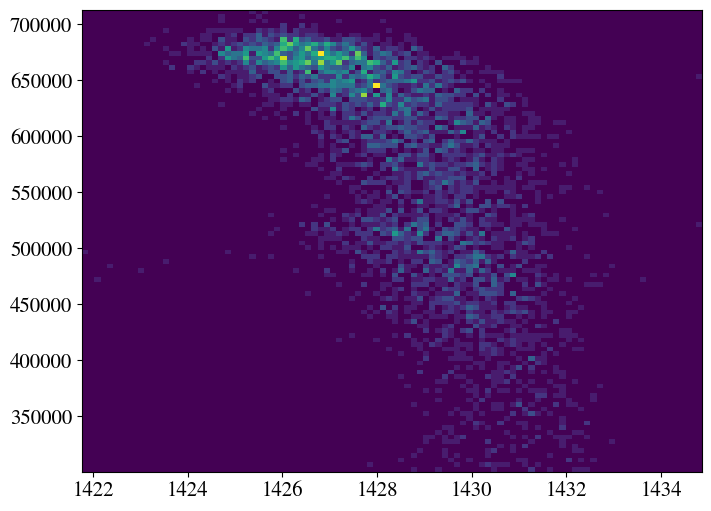

In [88]:
plt.hist2d(data[drfit_cut].DT, data[drfit_cut].S2e, [100,100]);

In [89]:
def find_max_min(data, cut):

    x = data[cut].DT
    y = data[cut].S2e

    # Define bin edges (adjust as necessary)
    x_bins = np.linspace(x.min(), x.max(), 101)  # 100 bins for x
    y_bins = np.linspace(y.min(), y.max(), 101)  # 100 bins for y

    # Compute the histogram
    hist, xedges, yedges = np.histogram2d(x, y, bins=[x_bins, y_bins])

    # Extract the min and max counts for this specific histogram
    local_min = hist.min()
    local_max = hist.max()
    
    return local_min, local_max
    
    

In [90]:
a, b = find_max_min(data, diff_cut)

In [91]:
a,b

(0.0, 19.0)

In [92]:
def plot(data, cut):
    
    x = data[cut].DT
    y = data[cut].S2e

    # Define bin edges (adjust as necessary)
    x_bins = np.linspace(x.min(), x.max(), 101)  # 100 bins for x
    y_bins = np.linspace(y.min(), y.max(), 101)  # 100 bins for y
    
    plt.figure(figsize=(8, 6))
    h = plt.hist2d(x, y, bins=[x_bins, y_bins], vmin=0, vmax=31, cmap="viridis")
    cbar = plt.colorbar(h[3])  # Add color bar (h[3] is the QuadMesh object from hist2d)
    cbar.set_label("Counts")  # Label for the color bar

    # Axis labels and title
    plt.xlabel("Drift Time [mus]")
    plt.ylabel("S2 Energy [pes]")
    plt.title("Histogram S2 Energy vs Drift Time (Run 14440)")
    plt.tight_layout()
    plt.show()

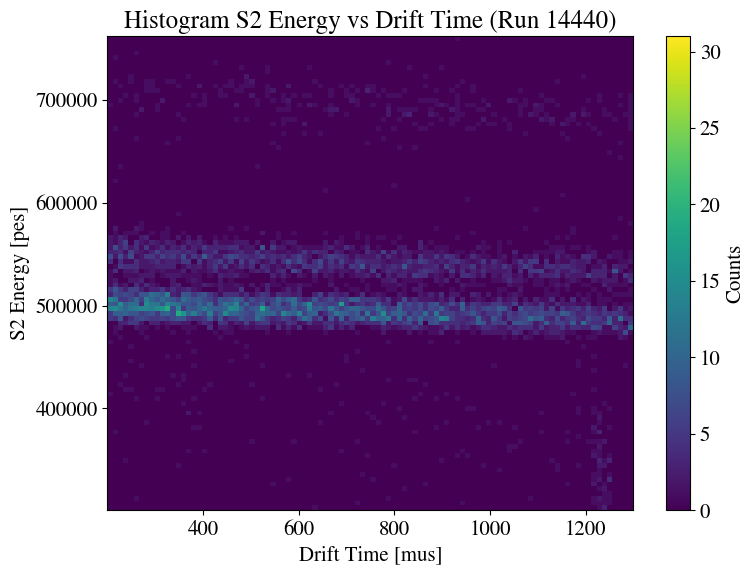

In [93]:
plot(data, diff_cut)

In [94]:
def main(data, axis):
    
    cathode_voltage = 17996.5
    gate_voltage = 6001.5
    detector_pressure = 4.018
    T_0 = 293.15
    detector_temp = 294.15
    
    population_A = '$^{222}Rn$ Population'
    population_B = '$^{218}Po$ Population'
    
    cut_drift, cut_diff = selection_cuts(data)
    
    drift_velocity, drift_velocity_error = drift_velocity_calculation(data, cut_drift)
    
    plot_velocity(data, cut_drift)
    
    population_A_cut, population_B_cut = population_cuts(data, cut_diff)
    
    lifetime_A, lifetime_A_error = calculate_lifetime(data, population_A_cut, "population_A_cut")
    lifetime_B, lifetime_B_error = calculate_lifetime(data, population_B_cut, "population_B_cut")
    
    values_A, covariance_A, inliers_A = ransac_fit(data, population_A_cut, axis, drift_velocity)
    
    plot_fit(data, population_A_cut, inliers_A, values_A, drift_velocity, population_A, axis)
    
    diffusion, sigma_0, diffusion_error, sigma_0_error = calculate_diffusion(data, population_A_cut, axis, drift_velocity, population_A)
    
    diffusion_converted = diffusion * 10000 # cm^2/s
    drift_velocity_converted = drift_velocity * 10e6 # mm/s
    error_diffusion_converted = diffusion_error * 10000
    error_drift_velocity_converted = drift_velocity_error * 10e6
    
    corrected_diffusion, corrected_diffusion_error = calculate_corrected_diffusion(
        drift_velocity_converted, diffusion_converted, detector_pressure, detector_temp, 
        T_0, error_drift_velocity_converted, error_diffusion_converted, axis
    )
    
    return corrected_diffusion, corrected_diffusion_error

Dift Velocity (Whole Population) = 0.8314 ± 0.0007 [mm / mus]


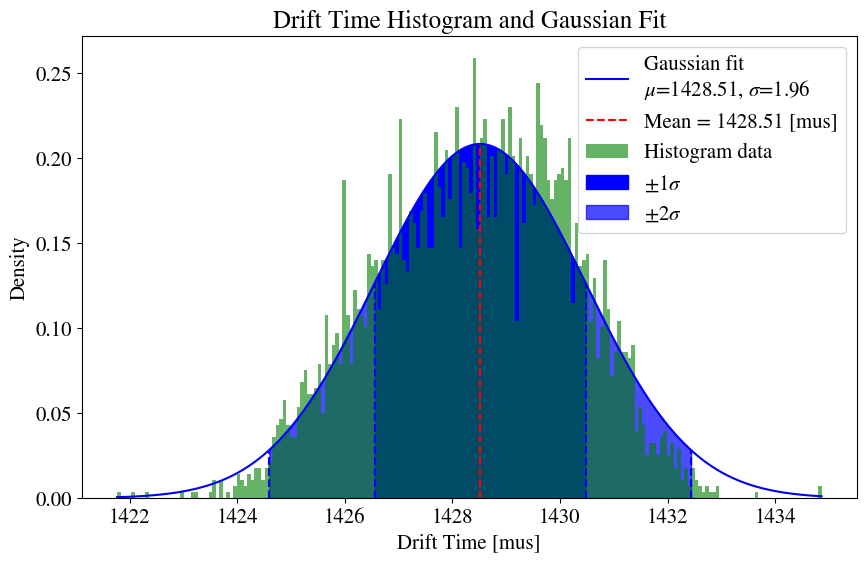

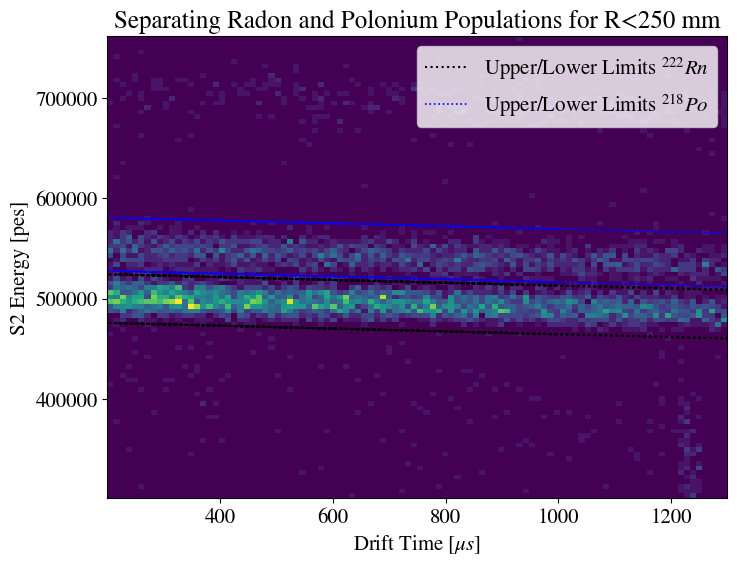


Lifetime fit [Rn 222]
Lifetime = 36924.2712 ± 1203.3984 [mus]
E_0: 504147.79642025527 ± 324.3076 [pes]


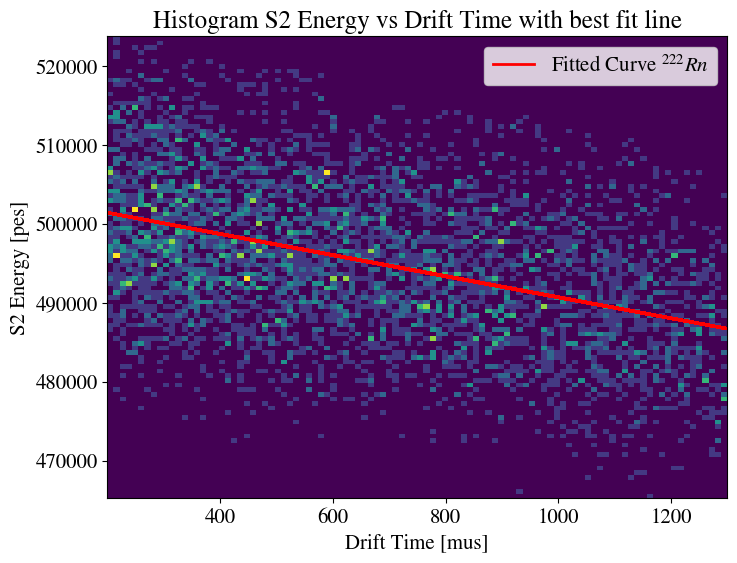


Lifetime fit [Po 218]
Lifetime = 34735.7177 ± 1634.8491 [mus]
E_0: 553832.5856270881 ± 566.1347 [pes]


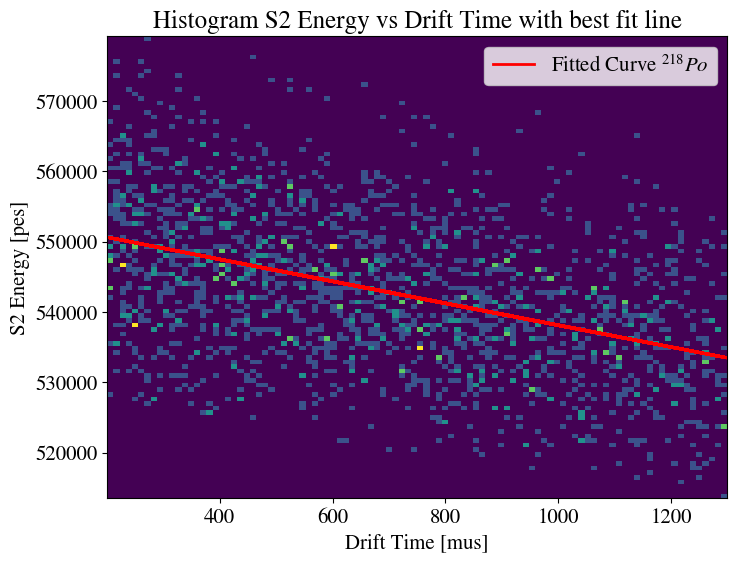

[ 0.02044412 18.65484061]
[ 0.02044412 18.65484061]


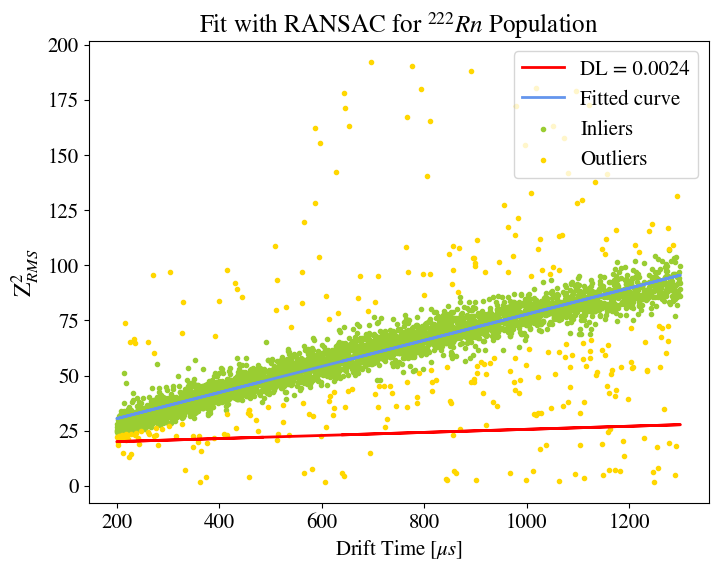

Longitudinal Diffusion Coefficient $^{222}Rn$ Population = 0.0207 ± 0.0004 [mm^2/mus]
Initial Spread Squared $^{222}Rn$ Population = 18.1114 ± 0.6239 [mus^2]
DL* = 446.0547 ± 4.3602 [sqrt(bar)*mum/sqrt(cm)]


In [131]:
longitudinal_diffusion, longitudinal_diffusion_error = main(data, 'Zrms')

Dift Velocity (Whole Population) = 0.8314 ± 0.0007 [mm / mus]


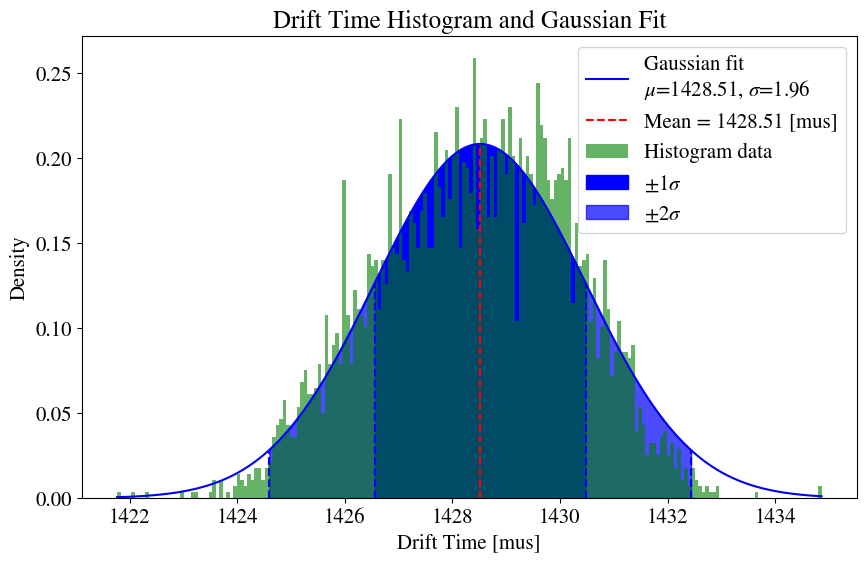

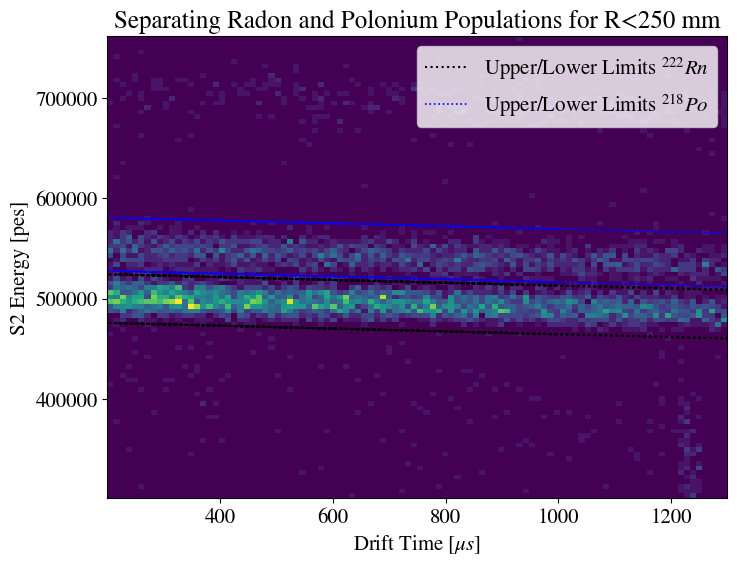


Lifetime fit [Rn 222]
Lifetime = 36924.2712 ± 1203.3984 [mus]
E_0: 504147.79642025527 ± 324.3076 [pes]


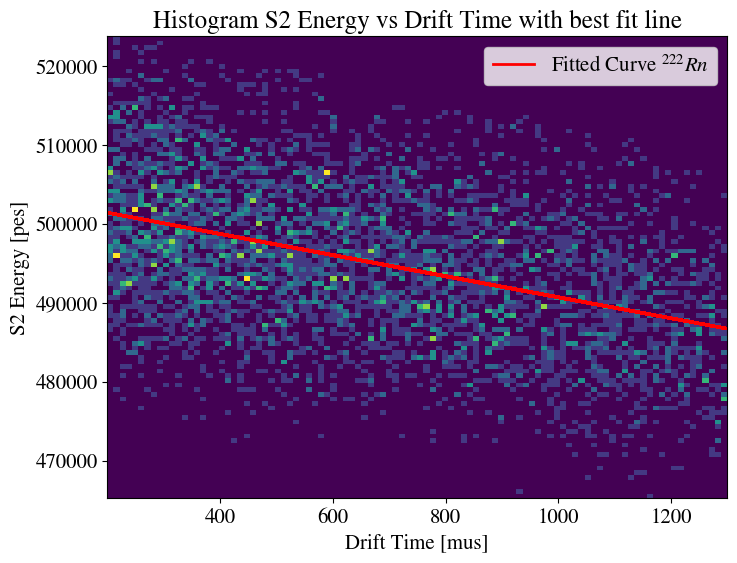


Lifetime fit [Po 218]
Lifetime = 34735.7177 ± 1634.8491 [mus]
E_0: 553832.5856270881 ± 566.1347 [pes]


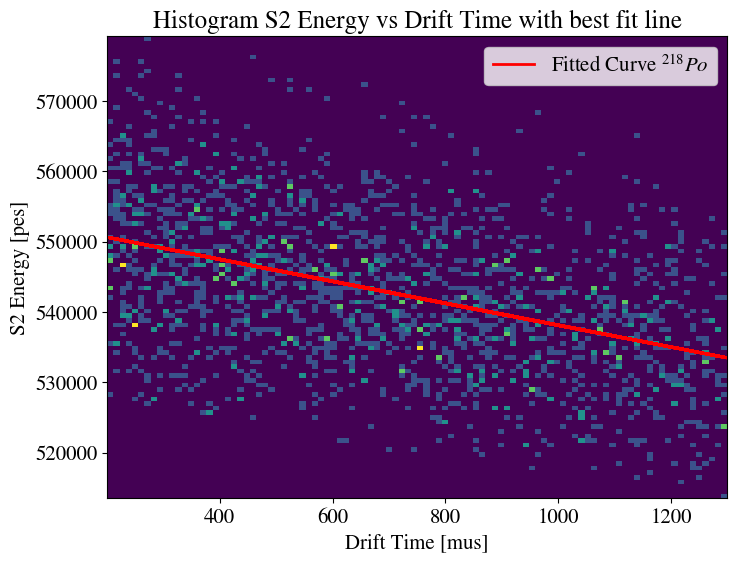

[8.6824405e-02 6.0751561e+02]


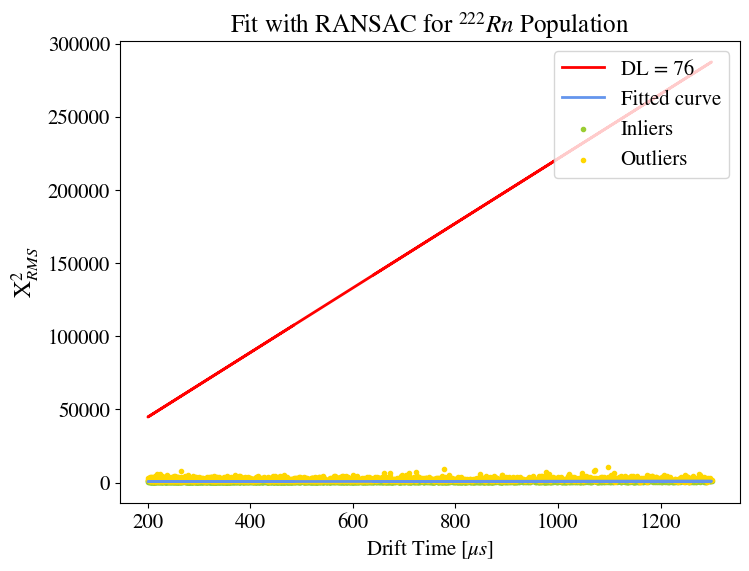

Longitudinal Diffusion Coefficient $^{222}Rn$ Population = 0.0712 ± 0.0569 [mm^2/mus]
Initial Spread Squared $^{222}Rn$ Population = 661.5729 ± 118.1781 [mus^2]
DT* = 828.0730 ± 330.9754 [sqrt(bar)*mum/sqrt(cm)]


In [126]:
longitudinal_diffusion, longitudinal_diffusion_error = main(data, 'Xrms')

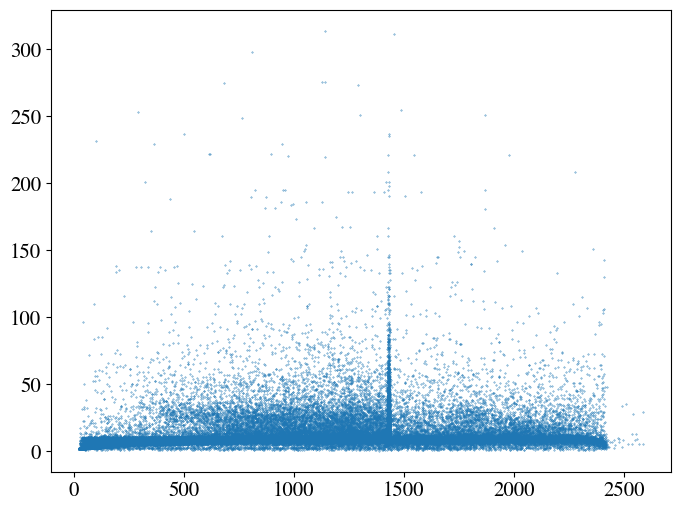

In [97]:
#display(data)
plt.scatter(data.DT, data.Zrms, s = 0.1)

plt.show()

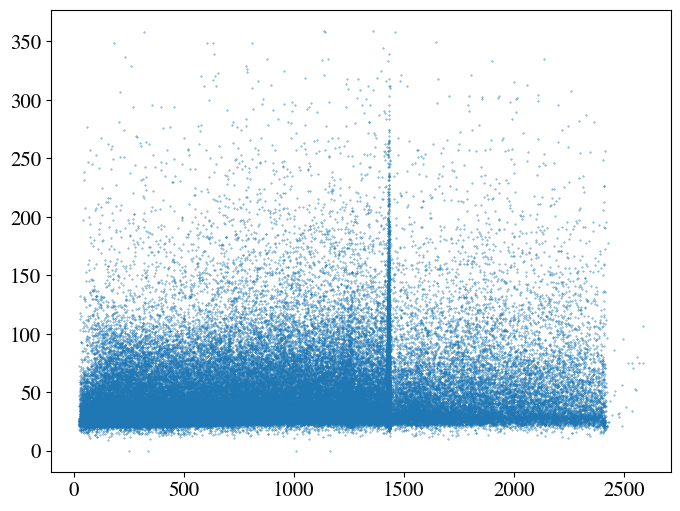

In [100]:
plt.scatter(data.DT, data.Xrms, s = 0.1)

0.002413411641062937
1200
Dift Velocity (Whole Population) = 0.8314 ± 0.0007 [mm / mus]


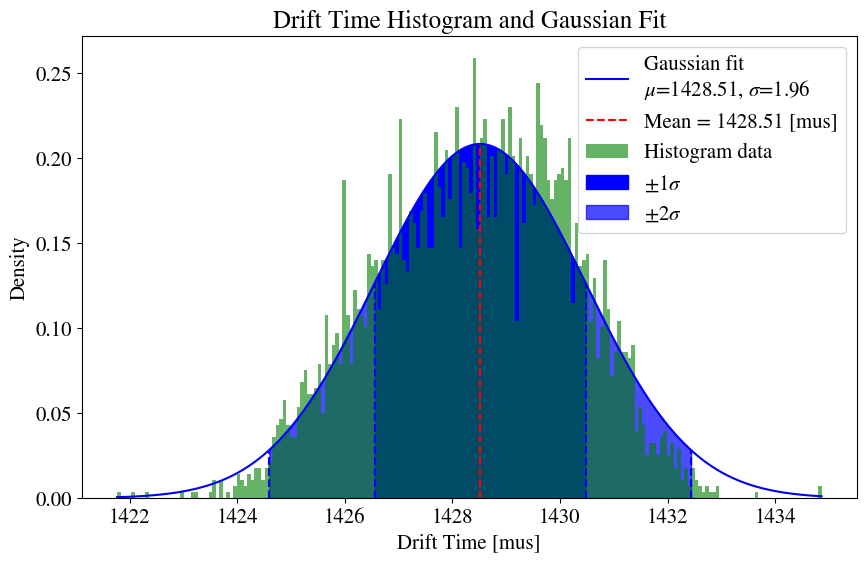

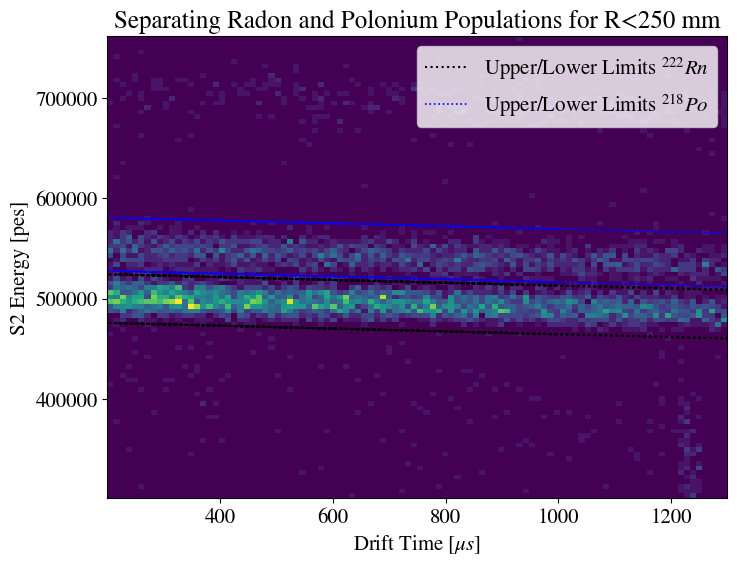

Text(0, 0.5, 'XRms')

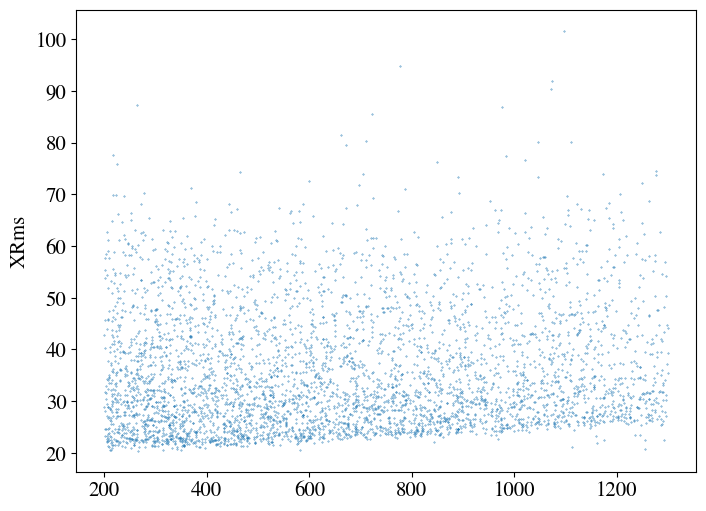

In [129]:
    
cathode_voltage = 17996.5
gate_voltage = 6001.5
detector_pressure = 4.018
T_0 = 293.15
detector_temp = 294.15

drift_velocity = 0.8314

corrected_DL = 1200

uncorrected_DL = (corrected_DL/(10000 * np.sqrt(10)))**2 * (detector_temp / T_0) * (drift_velocity / 2 * detector_pressure)
print(uncorrected_DL)
#corrected_DL = np.sqrt((T_0/detector_temp)*(2*detector_pressure* DL/drift_velocity)) * 10000 * np.sqrt(10) # to convert from cm/sqrt(mm) to mum/sqrt(cm)
print(corrected_DL)

population_A = '$^{222}Rn$ Population'
population_B = '$^{218}Po$ Population'
    
cut_drift, cut_diff = selection_cuts(data)
    
drift_velocity, drift_velocity_error = drift_velocity_calculation(data, cut_drift)
    
plot_velocity(data, cut_drift)
    
population_A_cut, population_B_cut = population_cuts(data, cut_diff)

plt.scatter(data.DT[population_A_cut], data.Xrms[population_A_cut], s = 0.1)
plt.ylabel("XRms")

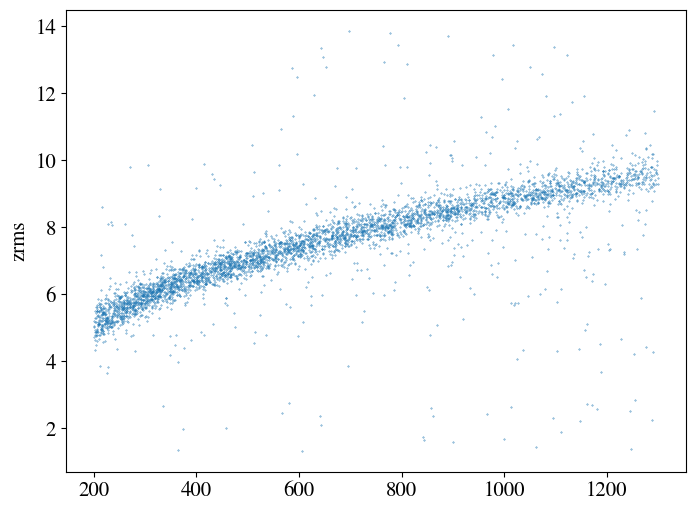

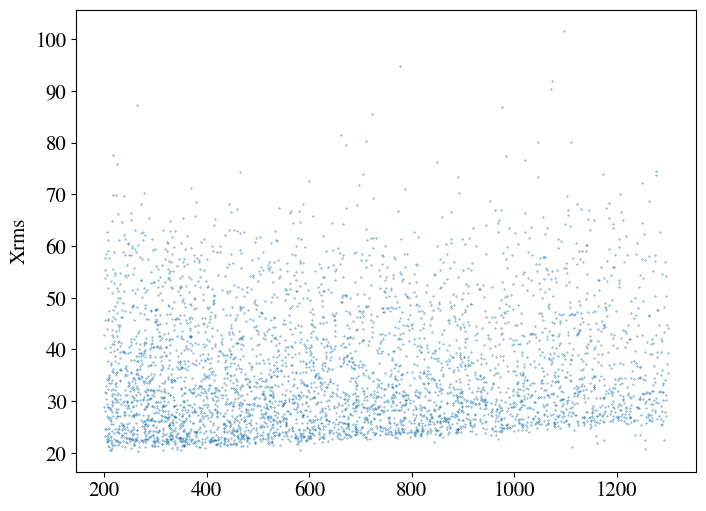

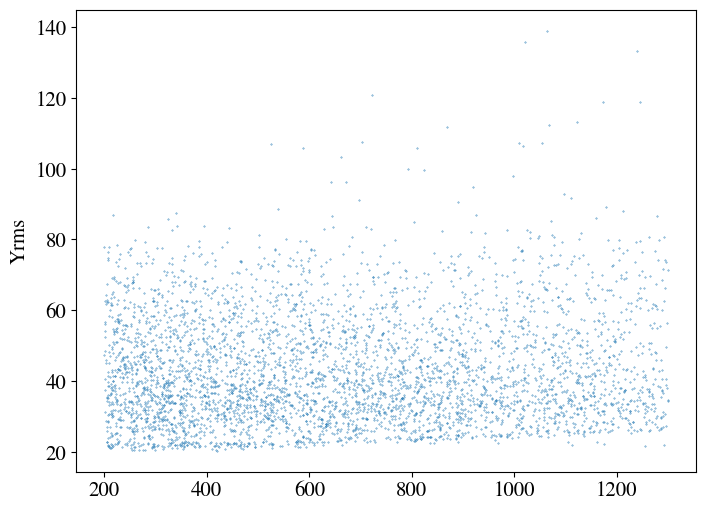

In [104]:
plt.scatter(data.DT[population_A_cut], data.Zrms[population_A_cut], s = 0.1)
plt.ylabel('zrms')
plt.show()



plt.scatter(data.DT[population_A_cut], data.Xrms[population_A_cut], s = 0.1)
plt.ylabel('Xrms')
#plt.ylim([10, 40])
plt.show()

plt.scatter(data.DT[population_A_cut], data.Yrms[population_A_cut], s = 0.1)
plt.ylabel('Yrms')
#plt.ylim([10, 40])
plt.show()